## Basics of Time Series

### Setup

In [2]:
!pip install tf-nightly

     |████████████████████████████████| 442.7 MB 33 kB/s 
     |████████████████████████████████| 5.5 MB 22.6 MB/s 
     |████████████████████████████████| 463 kB 47.4 MB/s 
     |████████████████████████████████| 4.3 MB 18.5 MB/s 
     |████████████████████████████████| 12.8 MB 141 kB/s 
     |████████████████████████████████| 1.3 MB 59.7 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: keras-nightly
    Found existing installation: keras-nightly 2.5.0.dev2021032900
    Uninstalling keras-nightly-2.5.0.dev2021032900:
      Successfully uninstalled keras-nightly-2.5.0.dev2021032900
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires grpcio~=1.34.0, but you have grpcio 1.39.0 which is incompatible.
tensorfl

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
# for plotting series

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

### Trend and Seasonality

In [5]:
# for returning trend

def trend(time, slope=0):
    return slope * time

Let's create a time series that just trends upward:

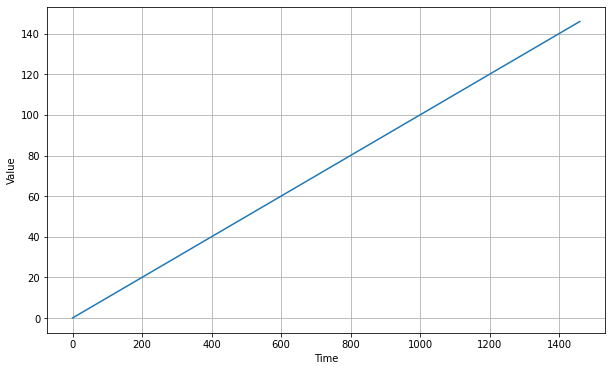

In [6]:
# simple time series -> time vs value

time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a time series with a seasonal pattern:

In [7]:
# adding seasonality

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

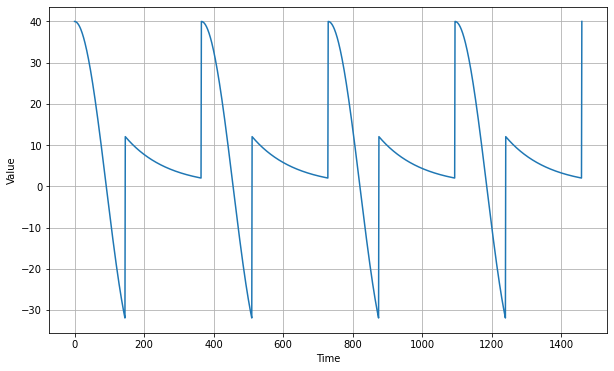

In [8]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a time series with both trend and seasonality:

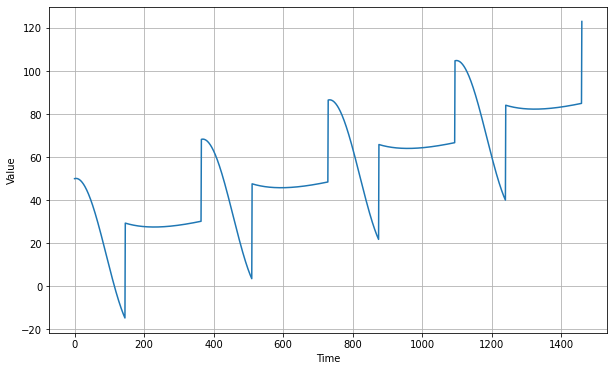

In [9]:
# trend + seasonality

slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [10]:
# adding noise to series

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

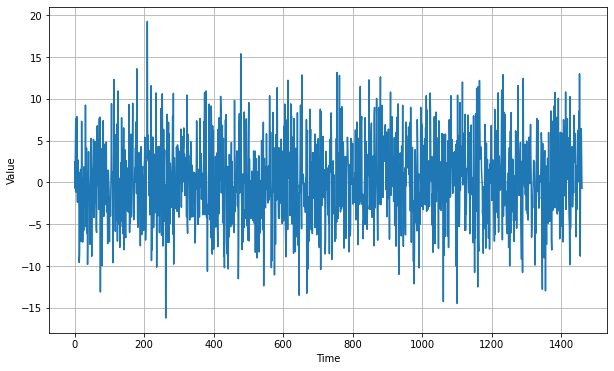

In [11]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add this white noise to the time series:

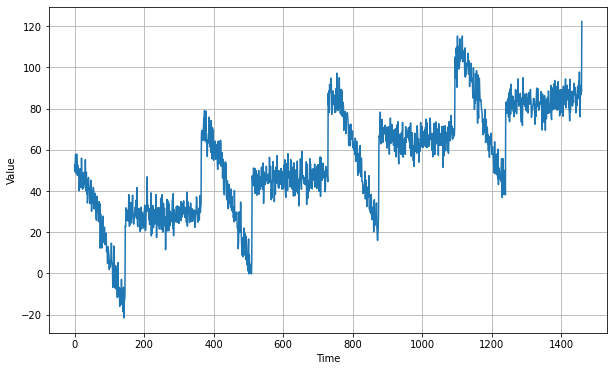

In [12]:
# adding noise to trend + seasonality

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [13]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [14]:
# autocorrelation 1

def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

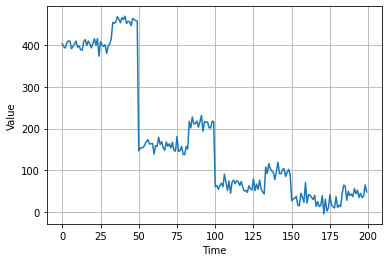

In [15]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

In [16]:
# autocorrelation 2

def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

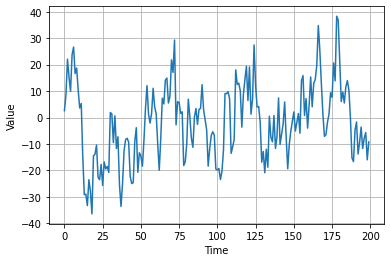

In [17]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

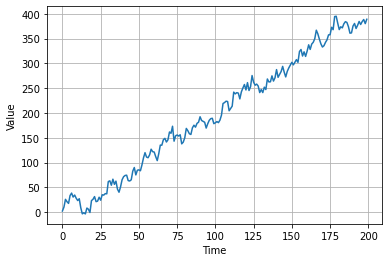

In [18]:
# autocorr + trend

series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

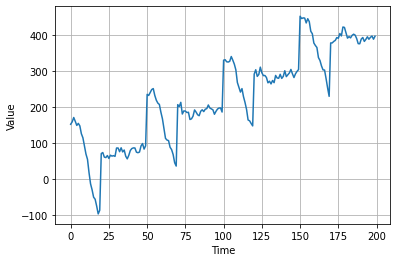

In [19]:
# autocorr + trend + seasonality

series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

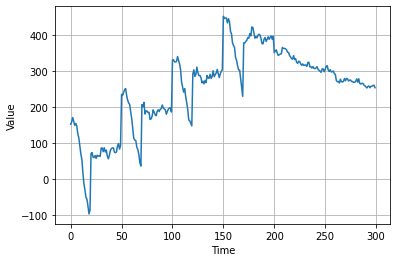

In [20]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)          # up trend
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550     # down trend
series[200:] = series2[200:]
plot_series(time[:300], series[:300])
plt.show()

In [22]:
# adding impulses

def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

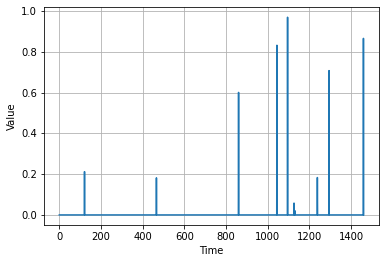

In [23]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [24]:
# adding auto corr to above

def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

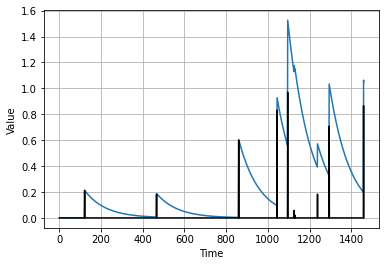

In [25]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

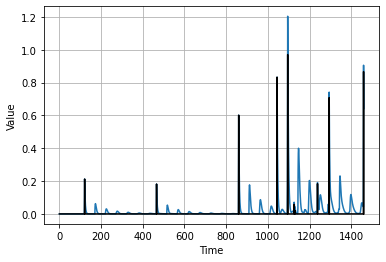

In [26]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

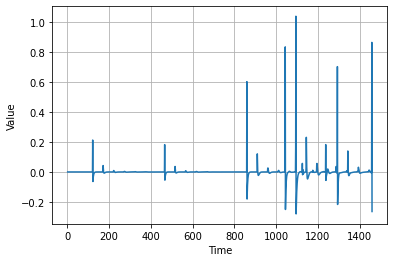

In [27]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

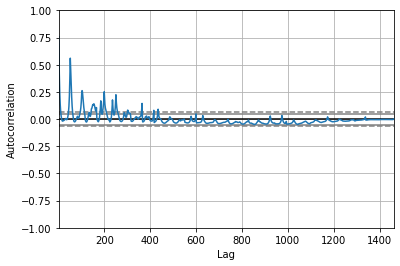

In [28]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [29]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Wed, 11 Aug 2021   AIC                          -4432.855
Time:                        04:08:25   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.715      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

### Running Sunspots data

In [33]:
df = pd.read_csv("Sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

In [34]:
df.head()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


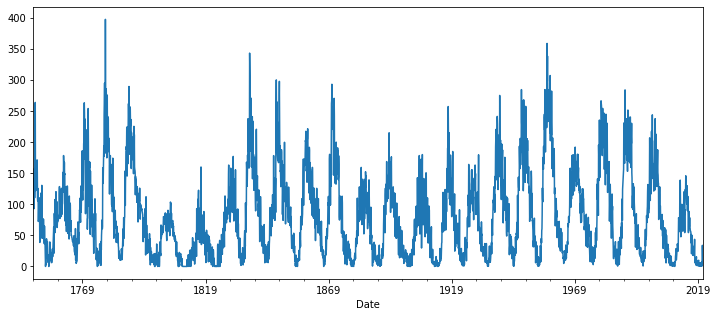

In [35]:
series.plot(figsize=(12, 5))

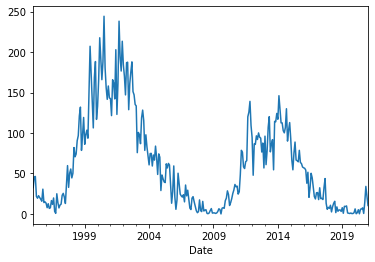

In [36]:
series["1995-01-01":].plot()

(0.0, 100.0, -50.0, 50.0)

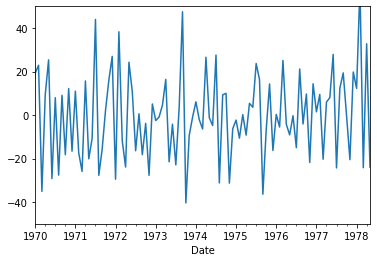

In [37]:
# applying 1 diff to remove trend and seasonality

series.diff(1).plot()
plt.axis([0, 100, -50, 50])

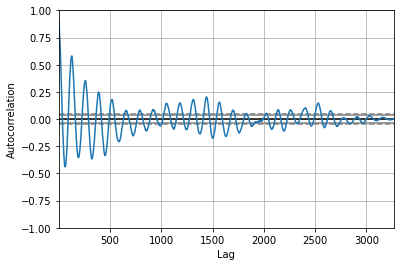

In [38]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

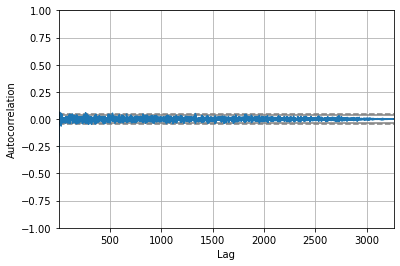

In [39]:
autocorrelation_plot(series.diff(1)[1:])

(0.0, 500.0, -0.1, 0.1)

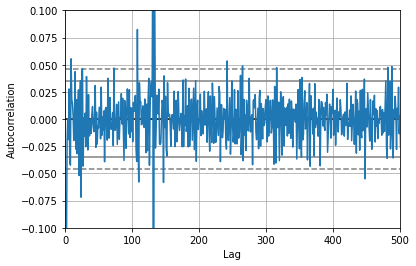

In [40]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

(0.0, 50.0, -0.1, 0.1)

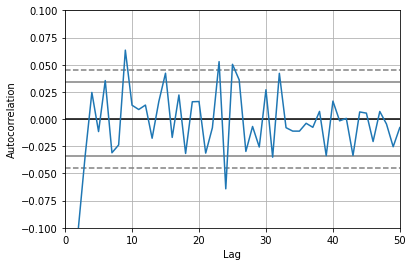

In [41]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [42]:
116.7 - 104.3

12.400000000000006

In [43]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9182467517244699,
 0.8860314675907544,
 0.8700859122855187,
 0.8596131174051874,
 0.8451708761214051,
 0.8325965318271723,
 0.8142618537636366,
 0.8009023400742292,
 0.7914472106297713,
 0.7715964858658894,
 0.7502927205937704,
 0.726884338151892,
 0.701322895306846,
 0.6786429949066952,
 0.6533297890337183,
 0.6210620765307739,
 0.5915480432972883,
 0.5583968547228386,
 0.5303783891321736,
 0.4997651188716434,
 0.4664494790057142,
 0.4382438732744969,
 0.4113361871304737,
 0.3756857991958743,
 0.35060801667185637,
 0.31722994167238716,
 0.27789048176689474,
 0.24342538761999083,
 0.2100571293002743,
 0.1809470701445057,
 0.14732334769300304,
 0.11953585035853213,
 0.08483999797636099,
 0.051416983573674364,
 0.01976698716527696,
 -0.010051035153073628,
 -0.03924592482682628,
 -0.06721901678897518,
 -0.0964207671745006,
 -0.12002061018481741,
 -0.1462012061159967,
 -0.17214652044799056,
 -0.19836293254853693,
 -0.21895351970191293,
 -0.24063743094381804,
 -0.26317525282253396,
 -0.2

## Forecasting